### First need to collect data from Kaggle

In [55]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("philiphyde1/nfl-stats-1999-2022")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\gharr\.cache\kagglehub\datasets\philiphyde1\nfl-stats-1999-2022\versions\17


### Now need to remove unneeded columns

In [56]:
import pandas as pd 
path = path.replace("\\", "/")  # For Windows compatibility
df = pd.read_csv(f"{path}\\yearly_player_stats_offense.csv")

print(df.head())
column_names_list = df.columns.tolist()
print("\nColumn names (Python list):")
print(column_names_list)



    player_id      player_name position  birth_year  draft_year  draft_round  \
0  00-0000865    Charlie Batch       QB        1974      1998.0          2.0   
1  00-0004541    Donald Driver       WR        1975      1999.0          7.0   
2  00-0006101    Tony Gonzalez       TE        1976      1997.0          1.0   
3  00-0006101    Tony Gonzalez       TE        1976      1997.0          1.0   
4  00-0007091  Matt Hasselbeck       QB        1975      1998.0          6.0   

   draft_pick  draft_ovr  height  weight  ... delta_comp_pct  delta_int_pct  \
0        30.0       60.0    74.0   216.0  ...       0.220036           -1.0   
1         7.0      213.0    72.0   194.0  ...       0.000000            NaN   
2        13.0       13.0    77.0   247.0  ...       0.000000            0.0   
3        13.0       13.0    77.0   247.0  ...       0.000000            NaN   
4        34.0      187.0    76.0   235.0  ...       0.149281           -1.0   

  delta_pass_td_pct delta_ypa delta_yptarget

### isolate positions

In [57]:
#need to have players that are only qb,wr,rb 
df_QB = df[df['position'].isin(['QB'])]
df_WR = df[df['position'].isin(['WR'])]
df_RB = df[df['position'].isin(['RB'])] 

print(df_QB.head())

     player_id      player_name position  birth_year  draft_year  draft_round  \
0   00-0000865    Charlie Batch       QB        1974      1998.0          2.0   
4   00-0007091  Matt Hasselbeck       QB        1975      1998.0          6.0   
5   00-0010346   Peyton Manning       QB        1976      1998.0          1.0   
6   00-0010346   Peyton Manning       QB        1976      1998.0          1.0   
11  00-0019596        Tom Brady       QB        1977      2000.0          6.0   

    draft_pick  draft_ovr  height  weight  ... delta_comp_pct  delta_int_pct  \
0         30.0       60.0    74.0   216.0  ...       0.220036      -1.000000   
4         34.0      187.0    76.0   235.0  ...       0.149281      -1.000000   
5          1.0        1.0    77.0   230.0  ...       0.000000       0.000000   
6          1.0        1.0    77.0   230.0  ...       0.023426      -0.612245   
11        33.0      199.0    76.0   225.0  ...       0.000000      -1.000000   

   delta_pass_td_pct delta_ypa d

In [58]:
df_QB['fantasy_points_standard'].isna().sum()
df_RB['fantasy_points_ppr'].isna().sum()
df_WR['fantasy_points_ppr'].isna().sum()
target_columns = ['fantasy_points_standard', 'fantasy_points_ppr', 'fantasy_points_half_ppr']


In [66]:
import pandas as pd

# Example: start with your existing df
# df = pd.read_csv("player_stats.csv")

# If not already present:
df["games_played"] = 17 - df["games_missed"]

# Avoid divide-by-zero
df["games_played"] = df["games_played"].replace(0, pd.NA)

# Features to normalize (totals)
to_normalize = [
    "offense_snaps", "touches", "targets", "receptions",
    "rushing_yards", "receiving_yards", "yards_after_catch", "total_yards",
    "rush_touchdown", "receiving_touchdown", "total_tds",
    "rush_attempts", "rush_attempts_redzone", "targets_redzone",
    "touches", "total_yards", "rush_touchdown",
    "receiving_yards", "offense_snaps"
]

# Create new per-game versions
for col in to_normalize:
    df[f"{col}_pg"] = df[col] / df["games_played"]

# Keep static / rate-based features as-is
static_features = [
    "position", "age", "years_exp", "height", "weight",
    "team", "depth_team",
    "offense_pct", "team_offense_snaps",
    "yptarget", "yptouch", "ypc", "ypr",
    "rec_td_pct", "rush_td_pct", "td_pct",
    "team_targets_share", "team_rush_attempts_share", "team_receiving_yards_share",
    "games_missed",'fantasy_points_standard','fantasy_points_ppr',
]

# Combine everything into a new averaged feature DataFrame
avg_features = df[[*static_features, *[f"{c}_pg" for c in to_normalize]]].copy()

# Optionally inspect
print(avg_features.head())


  position   age  years_exp  height  weight team  depth_team  offense_pct  \
0       QB  37.0       14.0    74.0   216.0  PIT         3.0     1.000000   
1       WR  37.0       13.0    72.0   194.0   GB         2.0     0.190852   
2       TE  36.0       15.0    77.0   247.0  ATL         1.0     0.945736   
3       TE  36.0       15.0    77.0   247.0  ATL         1.0     0.911321   
4       QB  36.0       14.0    76.0   235.0  TEN         2.0     0.774510   

   team_offense_snaps  yptarget  ...  receiving_touchdown_pg  total_tds_pg  \
0               129.0       NaN  ...                0.000000      0.333333   
1               634.0      5.92  ...                0.200000      0.400000   
2               129.0      9.21  ...                0.125000      0.250000   
3              1060.0      7.69  ...                0.470588      0.941176   
4               510.0       NaN  ...                0.000000      0.777778   

   rush_attempts_pg  rush_attempts_redzone_pg  targets_redzone_pg  t

In [67]:
#now time to use these features to predict fantasy points for qbs, wrs, rbs
target_columns = ['fantasy_points_standard', 'fantasy_points_ppr',]   

df_QB_targets = df_QB[target_columns]
df_RB_targets = df_RB[target_columns]       
df_WR_targets = df_WR[target_columns]

#need to target each position separately 

In [81]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Example split by position
df_QB = avg_features[avg_features['position'] == 'QB'].copy()
df_WR = avg_features[avg_features['position'] == 'WR'].copy()
df_RB = avg_features[avg_features['position'] == 'RB'].copy()

# Define your target
target = 'fantasy_points_standard'  # Replace this with your actual target column

# Define features — exclude target and identifiers
features = [col for col in avg_features.columns if col not in ['position', 'team', 'depth_team', target,'fantasy_points_ppr', 'fantasy_points_half_ppr']]

# Function to train model for a given position
def train_position_model(df_position, position_name):
    # Drop rows missing the target
    df_position = df_position.dropna(subset=[target])
    
    X = df_position[features]
    print(len(X.columns))
    y = df_position[target]
    
    # Handle categorical variables
    X = pd.get_dummies(X, drop_first=True)
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Normalize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Model (Random Forest for example)
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"📊 {position_name} model performance:")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}\n")
    
    return model, scaler

# Train all three
QB_model, QB_scaler = train_position_model(df_QB, "Quarterback")
WR_model, WR_scaler = train_position_model(df_WR, "Wide Receiver")
RB_model, RB_scaler = train_position_model(df_RB, "Running Back")


46
📊 Quarterback model performance:
MAE: 9.71
R²: 0.99

46
📊 Wide Receiver model performance:
MAE: 4.66
R²: 0.98

46
📊 Running Back model performance:
MAE: 5.48
R²: 0.97



In [89]:
print(df_RB.fantasy_points_standard.mean())
print(len(RB_model.feature_importances_))
print(df_RB[features].columns)
print(RB_scaler.n_features_in_)

61.81536962750717
46
Index(['age', 'years_exp', 'height', 'weight', 'offense_pct',
       'team_offense_snaps', 'yptarget', 'yptouch', 'ypc', 'ypr', 'rec_td_pct',
       'rush_td_pct', 'td_pct', 'team_targets_share',
       'team_rush_attempts_share', 'team_receiving_yards_share',
       'games_missed', 'offense_snaps_pg', 'offense_snaps_pg', 'touches_pg',
       'touches_pg', 'targets_pg', 'receptions_pg', 'rushing_yards_pg',
       'receiving_yards_pg', 'receiving_yards_pg', 'yards_after_catch_pg',
       'total_yards_pg', 'total_yards_pg', 'rush_touchdown_pg',
       'rush_touchdown_pg', 'receiving_touchdown_pg', 'total_tds_pg',
       'rush_attempts_pg', 'rush_attempts_redzone_pg', 'targets_redzone_pg',
       'touches_pg', 'touches_pg', 'total_yards_pg', 'total_yards_pg',
       'rush_touchdown_pg', 'rush_touchdown_pg', 'receiving_yards_pg',
       'receiving_yards_pg', 'offense_snaps_pg', 'offense_snaps_pg'],
      dtype='object')
46


In [91]:
def graph_feature_importance(features, positionmodel,position_scaler, positionDF,position):
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    importances = positionmodel.feature_importances_
    feature_names = position_scaler.get_feature_names_out(input_features=positionDF[features].columns)
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title(f"Top 20 Feature Importances for {position} Model")
    plt.tight_layout()
    plt.show()
    

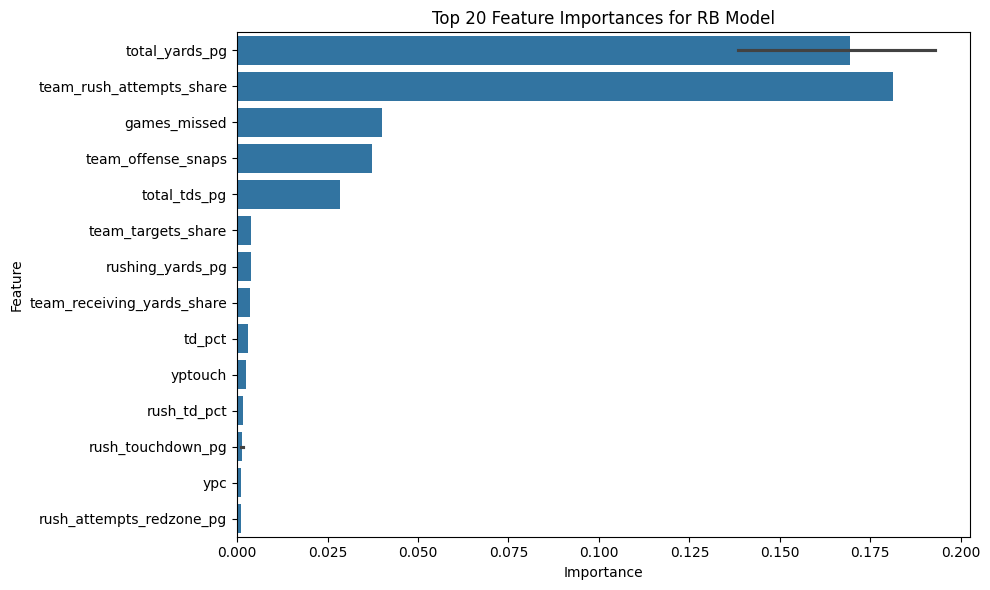

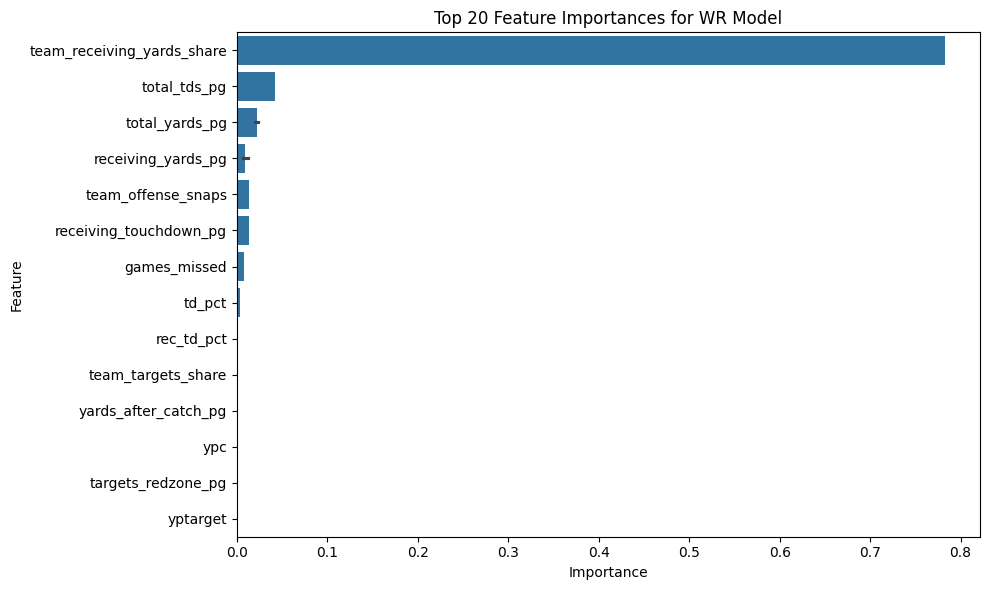

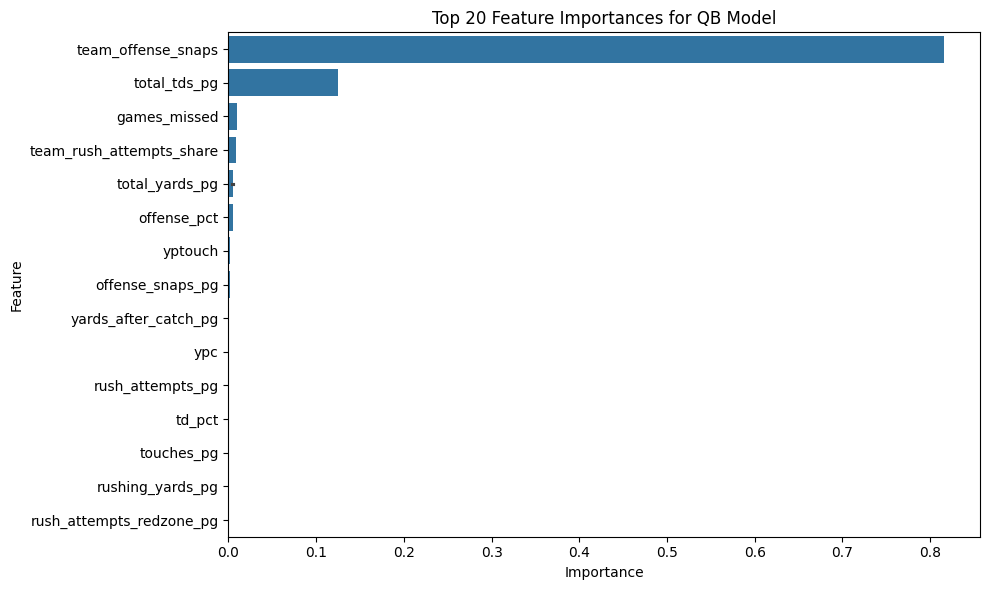

In [92]:
graph_feature_importance(features,RB_model,RB_scaler,df_RB,'RB')
graph_feature_importance(features,WR_model,WR_scaler,df_WR,'WR')
graph_feature_importance(features,QB_model,QB_scaler,df_QB,'QB')